## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star

%matplotlib inline

#from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
#?create_grid

If you would like to alter these implementations, you can modify [grid.py](grid.py) and [planning.py](planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-305.  -435.    85.5    5.     5.    85.5]
 [-295.  -435.    85.5    5.     5.    85.5]
 [-285.  -435.    85.5    5.     5.    85.5]
 ...
 [ 435.   465.     8.     5.     5.     8. ]
 [ 445.   465.     8.     5.     5.     8. ]
 [ 455.   465.     8.     5.     5.     8. ]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [6]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

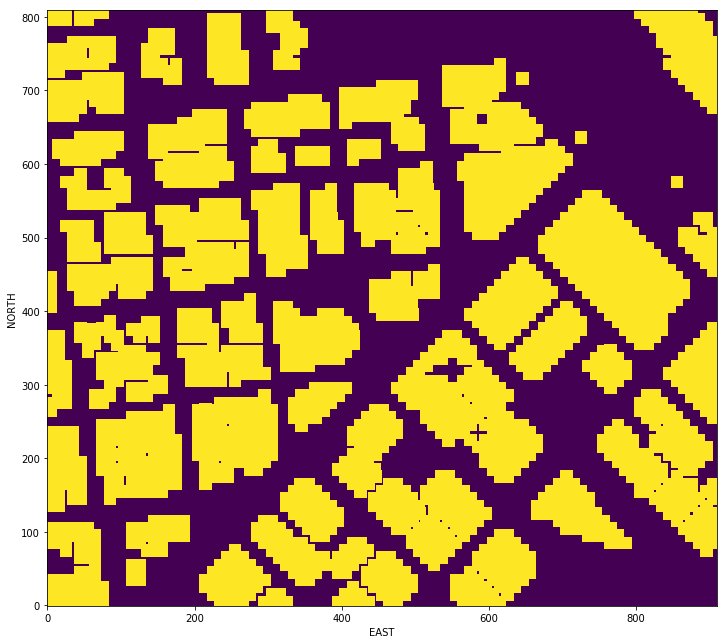

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [8]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [9]:
def heuristic_func(position, goal_position):
    # ord=1: Manhattan distance
    # ord=2: Euclidean distance
    h = np.linalg.norm((position[0]-goal_position[0], position[1]-goal_position[1]), ord=1)
    return h

Compute the lowest cost path with `a_star`. 

In [10]:
# use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(len(path), cost)

Found a path.
1025 500285.0


Let's plot the path!

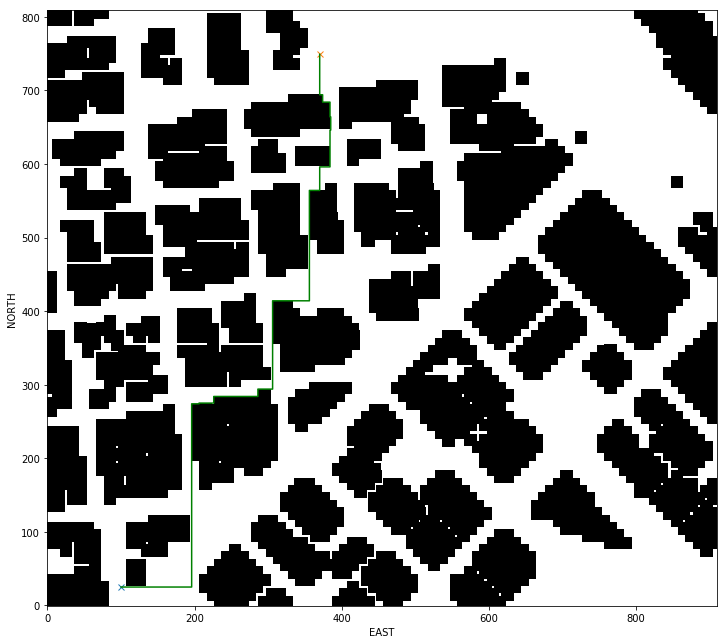

In [11]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [12]:
def bres(p1, p2): 
    """
    Note this solution requires `x1` < `x2` and `y1` < `y2`.
    """
    x1, y1 = p1
    x2, y2 = p2
    x_sign = 1 if x2 >= x1 else -1
    y_sign = 1 if y2 >= y1 else -1
    
    x1 *= x_sign
    x2 *= x_sign
    y1 *= y_sign
    y2 *= y_sign
    
    cells = []
    
    if x2 - x1 == 0:
        for y in range(y1, y2 + 1):
            cells.append((x1 * x_sign, y * y_sign))
        return np.array(cells)
        
    x = x1
    y = y1
    f = y1
    m = (y2 - y1) / (x2 - x1)
    # Determine valid grid cells
    while x < x2:
        cells.append((x * x_sign, y * y_sign))
        if f + m > y + 1:
            y += 1
        else:
            x += 1
            f += m
    return np.array(cells)

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [13]:
def prune_path(path):
    pruned_path = [p for p in path]
    
    # prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        valid = True
        p1 = pruned_path[i]
        p3 = pruned_path[i+2]
        for p in bres(p1, p3):
            if grid[p[0], p[1]] == 1:
                valid = False
                break
        if valid:
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
            
    return pruned_path

Prune the path.

In [14]:
pruned_path = prune_path(path)
print(len(pruned_path))

16


In [15]:
pruned_path

[(25, 100),
 (30, 196),
 (274, 196),
 (275, 207),
 (284, 226),
 (294, 286),
 (308, 306),
 (414, 306),
 (458, 356),
 (564, 356),
 (597, 384),
 (647, 385),
 (664, 385),
 (684, 384),
 (694, 374),
 (749, 370)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

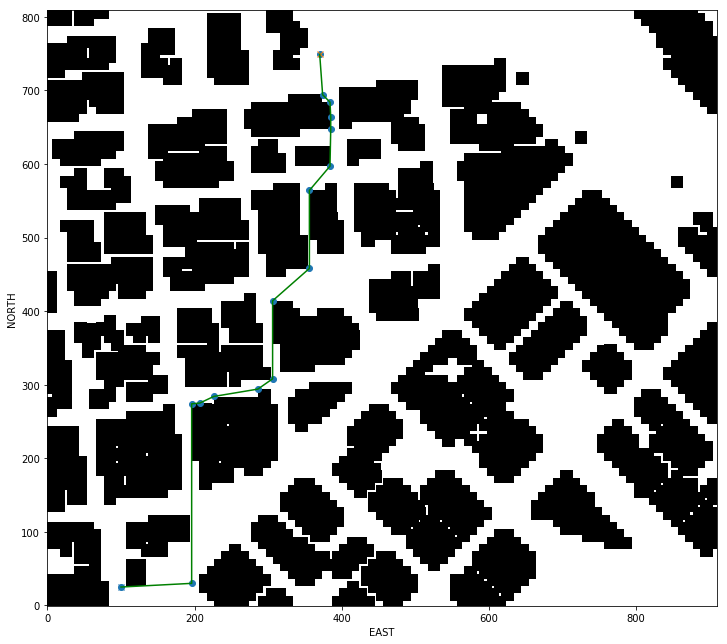

In [16]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!